In [1]:
import numpy as np
%matplotlib inline

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


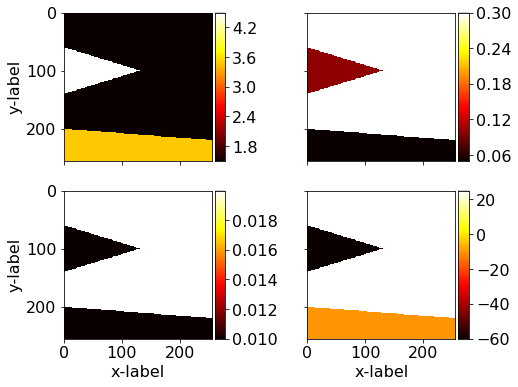

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, TimeAxis
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

# Define a physical size
shape = (256, 256)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # What is the location of the top left corner. This is necessary to define
# the absolute location of the source and receivers

space_order=4

#Load the velocity model and thomsem parameters
v = np.empty(shape, dtype=np.float32)
epsilon=np.empty(shape, dtype=np.float32)
delta=np.empty(shape, dtype=np.float32)
thetha=np.empty(shape, dtype=np.float32)

f= open('models/vel.ad', 'rb')
v = np.fromfile(f, dtype=np.float32)
f= open('models/eps.ad', 'rb')
epsilon = np.fromfile(f, dtype=np.float32)
f= open('models/delta.ad', 'rb')
delta = np.fromfile(f, dtype=np.float32)
f= open('models/theta.ad', 'rb')
theta = np.fromfile(f, dtype=np.float32)

v *= 1./1000
v = np.reshape(v, shape)
epsilon = np.reshape(epsilon, shape)
delta = np.reshape(delta, shape)
theta = np.reshape(theta, shape)

# With the velocity, delta, epsilon, theta, phi and model size defined, we can create the seismic model that
# encapsulates this properties. We also define the size of the absorbing layer as 10 grid points
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbpml=10, epsilon=epsilon, delta=delta,
                  theta=theta)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.subplots_adjust(wspace=0.2)
fig.subplots_adjust(hspace=0.2)

im1=ax1.imshow(v.T, cmap=plt.cm.hot) 
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("right", size="7%", pad="2%")
cb1 = colorbar(im1, cax=cax1)

im2=ax2.imshow(epsilon.T, cmap=plt.cm.hot) 
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = colorbar(im2, cax=cax2)

im3=ax3.imshow(delta.T, cmap=plt.cm.hot) 
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("right", size="7%", pad="2%")
cb3 = colorbar(im3, cax=cax3)

im4=ax4.imshow(theta.T, cmap=plt.cm.hot) 
ax4_divider = make_axes_locatable(ax4)
cax4 = ax4_divider.append_axes("right", size="7%", pad="2%")
cb4 = colorbar(im4, cax=cax4)

for ax in (ax1,ax2,ax3,ax4):
    ax.set(xlabel='x-label', ylabel='y-label')
for ax in (ax1,ax2,ax3,ax4):
    ax.label_outer()

In [40]:
from examples.seismic import Model, AcquisitionGeometry

# Source and receiver geometries
src_coordinates = np.empty((1, len(spacing)))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = model.origin[-1] + 2 * spacing[-1]

nrec = shape[0]

rec_coordinates = np.empty((nrec, len(spacing)))
rec_coordinates[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rec_coordinates[:, 1] = np.array(model.domain_size)[1] * .5
rec_coordinates[:, -1] = model.origin[-1] + 2 * spacing[-1]

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                                   t0=0.0, tn=4000., src_type='Ricker', f0=0.005)
dt = model.critical_dt
print(dt)

0.738


In [41]:
from sympy import cos, sin, sqrt
from examples.seismic import PointSource, Receiver, RickerSource
from examples.seismic.tti.operators import kernel_centered_2d, Gxx_centered_2d,Gzz_centered_2d
from devito import TimeFunction
from devito import Eq, Operator, TimeFunction
from devito import ConditionalDimension

save=False
time_order=2
stagg_u = stagg_v = None
u = TimeFunction(name='u', grid=model.grid, staggered=stagg_u,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=4)
v = TimeFunction(name='v', grid=model.grid, staggered=stagg_v,
                     save=geometry.nt if save else None,
                     time_order=time_order, space_order=4)

time_range=TimeAxis(start=0., stop=4000., step=dt)
src = RickerSource(name='src', grid=model.grid, f0=0.005,npoint=1, time_range=time_range)
rec = Receiver(name='rec', grid=model.grid, npoint=rec_coordinates.shape[0], time_range=time_range,
               coordinates=rec_coordinates)
#src = PointSource(name='src', grid=model.grid, time_range=geometry.time_axis,
#                      npoint=geometry.nsrc)
#rec = Receiver(name='rec', grid=model.grid, time_range=geometry.time_axis,
#                   npoint=geometry.nrec)

stencils= kernel_centered_2d(model, u, v, space_order)

stencils += src.inject(field=u.forward, expr=src * dt**2 / model.m)
stencils += src.inject(field=v.forward, expr=src * dt**2 / model.m)
stencils += rec.interpolate(expr=u + v)

nsnaps = 100               # desired number of equally spaced snaps
nt = time_range.num
print(nt)
factor = round(nt / nsnaps)  # subsequent calculated factor
print(f"factor is {factor}")

time_subsampled = ConditionalDimension('t_sub', parent=model.grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=4,
                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)
vsave = TimeFunction(name='usave', grid=model.grid, time_order=2, space_order=4,
                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)

solver_tti = Operator(stencils+ [Eq(usave, u)] + [Eq(vsave, v)], subs=model.spacing_map, name='ForwardTTI')
#solver_tti = Operator(stencils, subs=model.spacing_map, name='ForwardTTI')

5422
factor is 54


In [42]:
src.coordinates.data[0, :]=src_coordinates[0]# just the first source
solver_tti(time=nt - 1, dt=model.critical_dt, rec=rec, src=src)
g= open('shot_TTI.file', 'wb')
print(rec.data.shape)
np.transpose(rec.data).astype('float32').tofile(g)

print("Saving snaps file")
print("Dimensions: nz = {:d}, nx = {:d}".format(shape[-1] + 2 * model.nbpml, shape[0] + 2 * model.nbpml))
filename = "snaps_TTI.bin"
usave.data.tofile(filename)

Operator `ForwardTTI` run in 13.93 s


(5422, 256)
Saving snaps file
Dimensions: nz = 276, nx = 276


In [26]:
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic.tti import AnisotropicWaveSolver

# Solvers
solver_tti = AnisotropicWaveSolver(model, geometry, time_order=2,
                                       space_order=space_order)

In [27]:
rec1, u, v, summary = solver_tti.forward()

Operator `ForwardTTI` run in 13.80 s


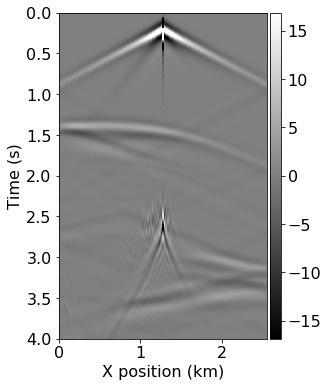

In [43]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_shotrecord

plot_shotrecord(rec.data, model, 0.0, 4000.)

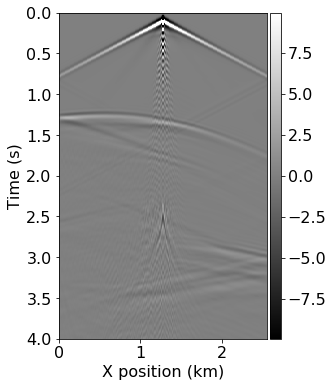

In [28]:
plot_shotrecord(rec1.data, model, 0.0, 4000.)